# Composite Environments: Merging Multiple Spaces

## Learning Objectives

By the end of this notebook, you will be able to:

- Understand when and why to use composite environments
- Merge multiple environments into a single unified space
- Work with automatic bridge inference using mutual nearest neighbors (MNN)
- Control bridge connectivity with distance thresholds
- Analyze multi-room and multi-compartment experiments
- Query across sub-environments seamlessly
- Visualize composite structures with bridges

**Estimated time: 25-30 minutes**

## What Are Composite Environments?

Many neuroscience experiments involve animals exploring **multiple separate environments**:

- **Multi-room experiments**: Animal switches between different rooms or contexts
- **Track segments**: Complex mazes with distinct sections (T-maze, plus-maze)
- **Context switching**: Same physical space with different configurations
- **Multi-scale analysis**: Different zoom levels or resolution in different areas

A `CompositeEnvironment` lets you:
1. Create separate `Environment` objects for each space
2. Merge them into a single unified environment
3. Automatically infer "bridge" connections between spaces
4. Query and analyze across all spaces with a single API

**Key insight:** The composite environment looks just like a regular `Environment` from the outside, but internally manages multiple sub-environments and their connections.

## Setup

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from shapely.geometry import Point

from neurospatial import Environment
from neurospatial.composite import CompositeEnvironment

np.random.seed(42)
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["font.size"] = 11

## Example 1: Two-Room Experiment

Let's start with a simple scenario: an animal explores two separate rooms. Each room is recorded separately, but we want to analyze neural activity across both contexts.

### Create Two Separate Environments

In [2]:
# Room 1: 50x50 cm square arena
# Simulate exploration with clustering in center
n_samples_room1 = 2000
room1_data = np.random.randn(n_samples_room1, 2) * 8 + np.array([25, 25])
room1_data = np.clip(room1_data, 5, 45)

env_room1 = Environment.from_samples(
    positions=room1_data, bin_size=4.0, name="Room1"
)

# Room 2: Different location, 40x60 cm rectangular arena
n_samples_room2 = 1500
room2_data = np.random.uniform(low=[60, 10], high=[95, 65], size=(n_samples_room2, 2))

env_room2 = Environment.from_samples(
    positions=room2_data, bin_size=4.0, name="Room2"
)

print(f"Room 1: {env_room1.n_bins} bins, range {env_room1.dimension_ranges}")
print(f"Room 2: {env_room2.n_bins} bins, range {env_room2.dimension_ranges}")

Room 1: 109 bins, range ((np.float64(3.0), np.float64(47.0)), (np.float64(3.0), np.float64(47.0)))
Room 2: 150 bins, range ((np.float64(58.02763288826266), np.float64(96.97726051652701)), (np.float64(8.0132552576824), np.float64(66.97033745828202)))


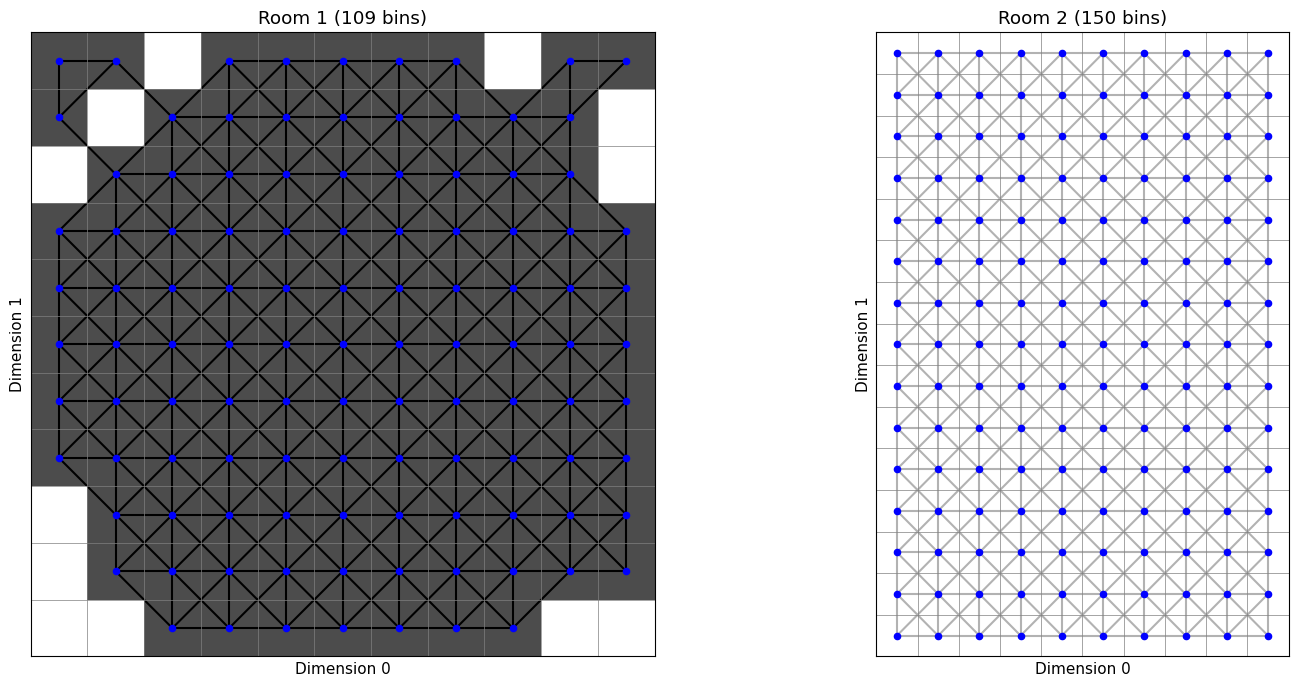

In [3]:
# Visualize the two rooms separately
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

env_room1.plot(ax=axes[0], show_connectivity=True)
axes[0].set_title(f"Room 1 ({env_room1.n_bins} bins)")
axes[0].set_aspect("equal")

env_room2.plot(ax=axes[1], show_connectivity=True)
axes[1].set_title(f"Room 2 ({env_room2.n_bins} bins)")
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

### Merge Into Composite Environment

In [4]:
# Create composite environment with automatic bridge inference
composite_env = CompositeEnvironment(
    subenvs=[env_room1, env_room2],
    auto_bridge=True,  # Automatically connect nearest bins
    max_mnn_distance=None,  # No distance limit (we'll explore this later)
)

print("Composite Environment Created!")
print(f"  Total bins: {composite_env.n_bins}")
print(f"  Sub-environments: {len(composite_env._subenvs_info)}")
print(f"  Bridge edges: {len(composite_env._bridge_list)}")
print(f"  Total edges: {composite_env.connectivity.number_of_edges()}")

Composite Environment Created!
  Total bins: 259
  Sub-environments: 2
  Bridge edges: 8
  Total edges: 904


### Understanding Bridges

**What are bridges?**
- Edges connecting bins from different sub-environments
- Inferred using **mutual nearest neighbors (MNN)** algorithm
- Allow paths and queries to work across the entire composite space

**MNN algorithm:**
For each pair of sub-environments:
1. Find the nearest bin in environment B for each bin in environment A
2. Find the nearest bin in environment A for each bin in environment B
3. Keep only the **mutual** nearest neighbors (A→B and B→A both agree)
4. Create bridge edges with proper distance weights

Let's examine the bridges:

In [5]:
# Examine the bridges in detail
print(f"\nBridge Details ({len(composite_env._bridge_list)} total):")
for i, ((i_env, i_bin), (j_env, j_bin), distance) in enumerate(
    composite_env._bridge_list[:5]
):  # Show first 5
    # Get composite bin indices
    bin1 = composite_env._subenvs_info[i_env]["start_idx"] + i_bin
    bin2 = composite_env._subenvs_info[j_env]["start_idx"] + j_bin
    pos1 = composite_env.bin_centers[bin1]
    pos2 = composite_env.bin_centers[bin2]
    print(
        f"  Bridge {i}: Bin {bin1} {pos1} ↔ Bin {bin2} {pos2}, distance={distance:.2f} cm"
    )


Bridge Details (8 total):
  Bridge 0: Bin 101 [45.  9.] ↔ Bin 109 [59.97511427  9.97849133], distance=15.01 cm
  Bridge 1: Bin 102 [45. 13.] ↔ Bin 110 [59.97511427 13.90896348], distance=15.00 cm
  Bridge 2: Bin 103 [45. 17.] ↔ Bin 111 [59.97511427 17.83943562], distance=15.00 cm
  Bridge 3: Bin 104 [45. 21.] ↔ Bin 112 [59.97511427 21.76990777], distance=14.99 cm
  Bridge 4: Bin 105 [45. 25.] ↔ Bin 113 [59.97511427 25.70037992], distance=14.99 cm


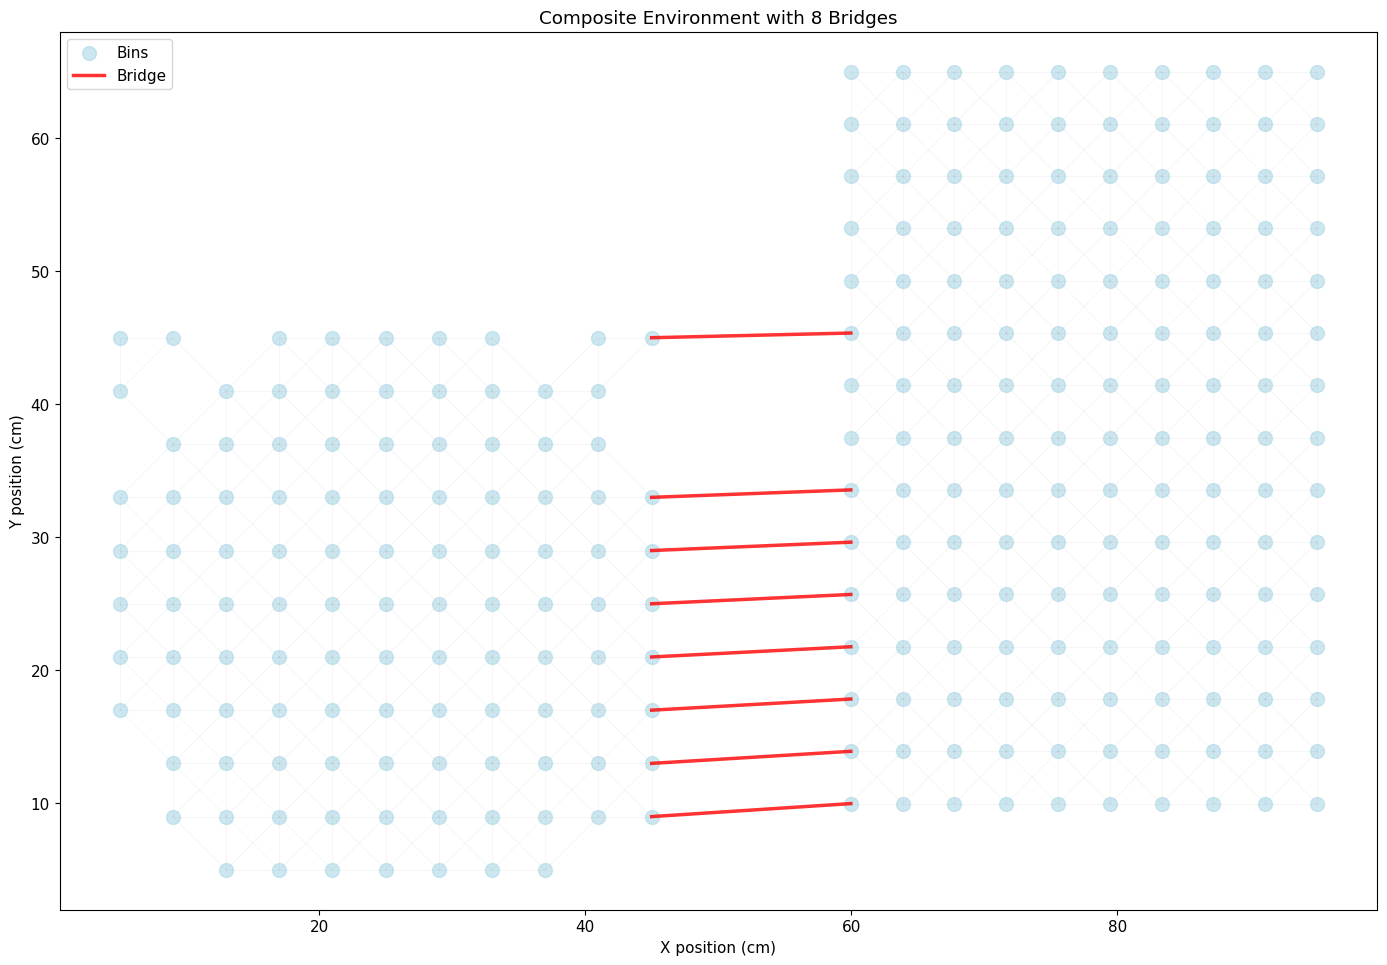

In [6]:
# Visualize the composite with bridges highlighted
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all bins
ax.scatter(
    composite_env.bin_centers[:, 0],
    composite_env.bin_centers[:, 1],
    c="lightblue",
    s=100,
    alpha=0.6,
    label="Bins",
)

# Convert bridge list to set of edges for fast lookup
bridge_edges = set()
for (i_env, i_bin), (j_env, j_bin), _ in composite_env._bridge_list:
    bin1 = composite_env._subenvs_info[i_env]["start_idx"] + i_bin
    bin2 = composite_env._subenvs_info[j_env]["start_idx"] + j_bin
    bridge_edges.add((min(bin1, bin2), max(bin1, bin2)))

# Draw regular edges (within environments) in gray
for edge in composite_env.connectivity.edges():
    edge_key = (min(edge[0], edge[1]), max(edge[0], edge[1]))
    if edge_key not in bridge_edges:
        pos1 = composite_env.bin_centers[edge[0]]
        pos2 = composite_env.bin_centers[edge[1]]
        ax.plot(
            [pos1[0], pos2[0]], [pos1[1], pos2[1]], "gray", alpha=0.1, linewidth=0.5
        )

# Highlight bridge edges in red
for i, ((i_env, i_bin), (j_env, j_bin), _) in enumerate(composite_env._bridge_list):
    bin1 = composite_env._subenvs_info[i_env]["start_idx"] + i_bin
    bin2 = composite_env._subenvs_info[j_env]["start_idx"] + j_bin
    pos1 = composite_env.bin_centers[bin1]
    pos2 = composite_env.bin_centers[bin2]
    ax.plot(
        [pos1[0], pos2[0]],
        [pos1[1], pos2[1]],
        "r-",
        linewidth=2.5,
        alpha=0.8,
        label="Bridge" if i == 0 else "",
    )

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title(f"Composite Environment with {len(composite_env._bridge_list)} Bridges")
ax.legend()
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Querying Across Sub-Environments

The composite environment provides the same API as a regular environment:

In [7]:
# Test points in different rooms
test_points = np.array(
    [
        [25.0, 25.0],  # Center of Room 1
        [75.0, 40.0],  # Center of Room 2
        [50.0, 50.0],  # Between rooms (outside both)
    ]
)

# Map to bins
bin_indices = composite_env.bin_at(test_points)
is_contained = composite_env.contains(test_points)

print("\nSpatial Queries:")
for _i, (point, bin_idx, contained) in enumerate(
    zip(test_points, bin_indices, is_contained, strict=False)
):
    status = "✓ IN" if contained else "✗ OUT"
    print(f"  Point {point}: bin={bin_idx}, {status}")


Spatial Queries:
  Point [25. 25.]: bin=53, ✓ IN
  Point [75. 40.]: bin=177, ✓ IN
  Point [50. 50.]: bin=-1, ✗ OUT


In [8]:
# Calculate distance between rooms
# Pick a bin from each room
point_room1 = np.array([25.0, 25.0])
point_room2 = np.array([75.0, 40.0])

# Geodesic distance (along the graph, through bridges)
geodesic_dist = composite_env.distance_between(point_room1, point_room2)

# Euclidean distance (straight line)
euclidean_dist = np.linalg.norm(point_room1 - point_room2)

print("\nDistance from Room 1 center to Room 2 center:")
print(f"  Euclidean (straight line): {euclidean_dist:.2f} cm")
print(f"  Geodesic (through graph): {geodesic_dist:.2f} cm")
print(f"  Difference: {geodesic_dist - euclidean_dist:.2f} cm")
print("\nNote: Geodesic is longer because it follows the connectivity graph.")


Distance from Room 1 center to Room 2 center:
  Euclidean (straight line): 52.20 cm
  Geodesic (through graph): 57.13 cm
  Difference: 4.92 cm

Note: Geodesic is longer because it follows the connectivity graph.


## Example 2: Controlling Bridge Connectivity

Sometimes you want to limit which environments connect to each other. The `max_mnn_distance` parameter controls this.

In [9]:
# Create three separate circular arenas at different locations
def create_circular_arena(
    center_x, center_y, radius=15, n_samples=800, bin_size=3.0, name="Arena"
):
    """Create a circular arena environment."""
    # Generate samples inside circle
    angles = np.random.uniform(0, 2 * np.pi, n_samples)
    radii = np.sqrt(np.random.uniform(0, 1, n_samples)) * (radius - 2)
    np.column_stack(
        [center_x + radii * np.cos(angles), center_y + radii * np.sin(angles)]
    )

    # Create environment
    circle_polygon = Point(center_x, center_y).buffer(radius)
    return Environment.from_polygon(
        polygon=circle_polygon, bin_size=bin_size, name=name
    )


# Create three arenas in a line
arena_a = create_circular_arena(20, 50, radius=15, name="Arena_A")
arena_b = create_circular_arena(60, 50, radius=15, name="Arena_B")
arena_c = create_circular_arena(100, 50, radius=15, name="Arena_C")

print(f"Arena A: {arena_a.n_bins} bins")
print(f"Arena B: {arena_b.n_bins} bins")
print(f"Arena C: {arena_c.n_bins} bins")

Arena A: 80 bins
Arena B: 80 bins
Arena C: 80 bins


In [10]:
# Compare different bridge distance thresholds
composites = {
    "No limit": CompositeEnvironment(
        subenvs=[arena_a, arena_b, arena_c], auto_bridge=True, max_mnn_distance=None
    ),
    "Within 15 cm": CompositeEnvironment(
        subenvs=[arena_a, arena_b, arena_c], auto_bridge=True, max_mnn_distance=15.0
    ),
    "Within 8 cm": CompositeEnvironment(
        subenvs=[arena_a, arena_b, arena_c], auto_bridge=True, max_mnn_distance=8.0
    ),
    "No bridges": CompositeEnvironment(
        subenvs=[arena_a, arena_b, arena_c],
        auto_bridge=False,  # Disable automatic bridging
    ),
}

print("Bridge counts with different thresholds:")
for name, comp_env in composites.items():
    print(f"  {name:15s}: {len(comp_env._bridge_list):3d} bridges")

Bridge counts with different thresholds:
  No limit       :  12 bridges
  Within 15 cm   :   8 bridges
  Within 8 cm    :   0 bridges
  No bridges     :   0 bridges


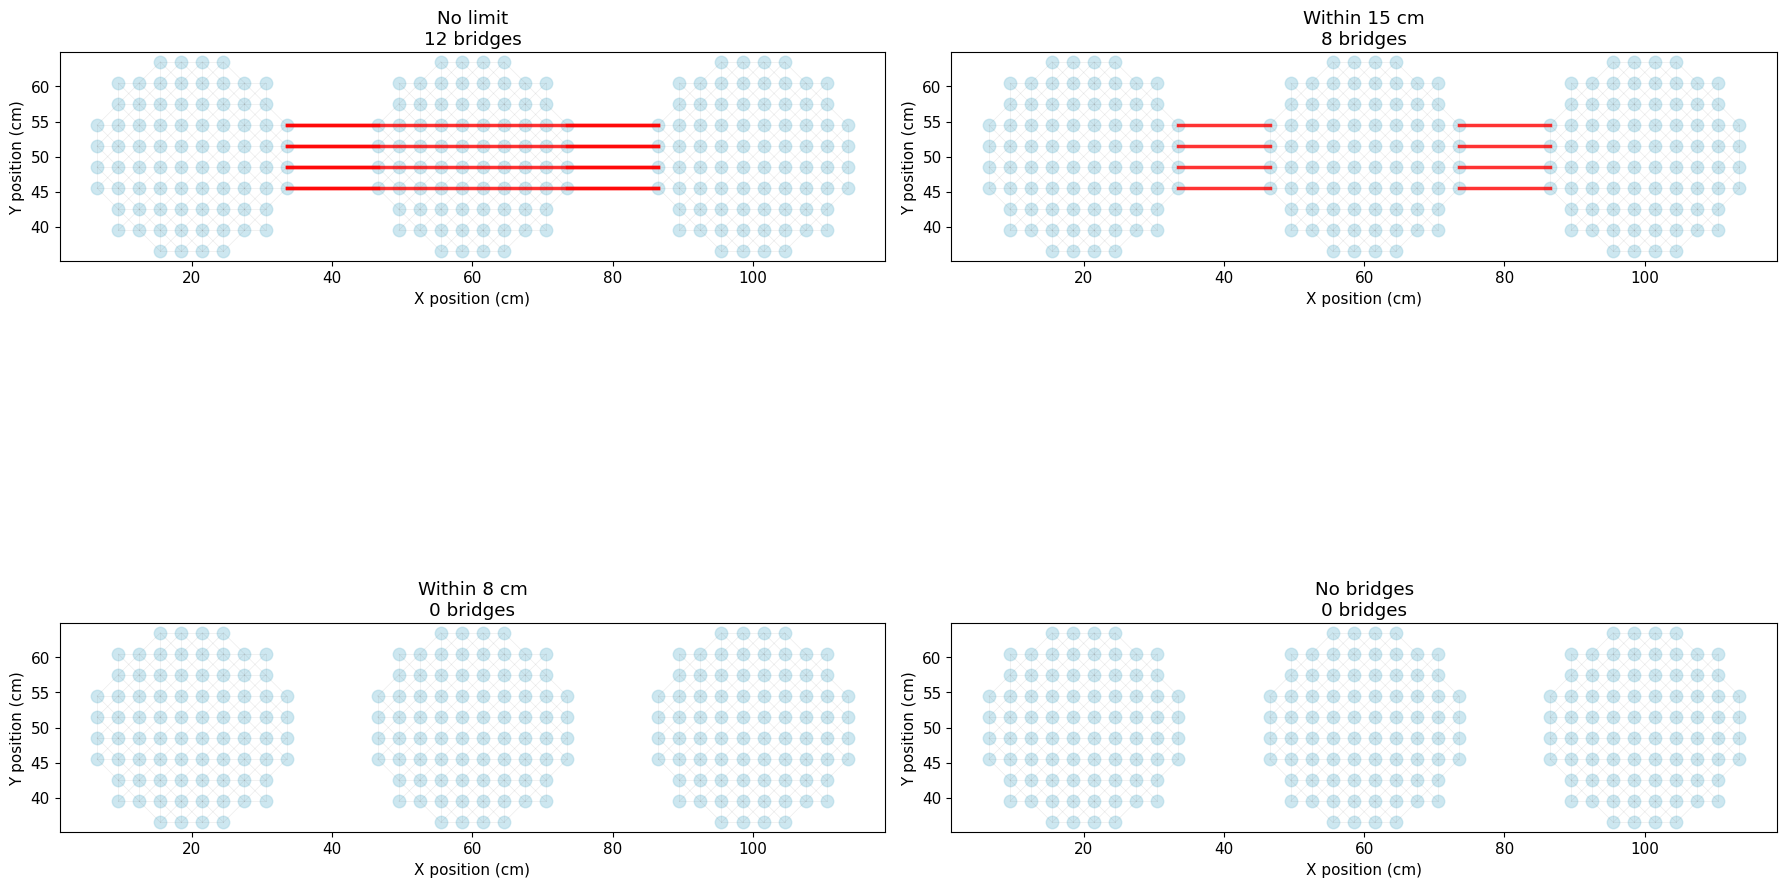

In [11]:
# Visualize the difference
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for ax, (title, comp_env) in zip(axes, composites.items(), strict=False):
    # Plot bins
    ax.scatter(
        comp_env.bin_centers[:, 0],
        comp_env.bin_centers[:, 1],
        c="lightblue",
        s=80,
        alpha=0.6,
    )

    # Convert bridge list to set of edges for fast lookup
    bridge_edges_set = set()
    for (i_env, i_bin), (j_env, j_bin), _ in comp_env._bridge_list:
        bin1 = comp_env._subenvs_info[i_env]["start_idx"] + i_bin
        bin2 = comp_env._subenvs_info[j_env]["start_idx"] + j_bin
        bridge_edges_set.add((min(bin1, bin2), max(bin1, bin2)))

    # Draw regular edges
    for edge in comp_env.connectivity.edges():
        edge_key = (min(edge[0], edge[1]), max(edge[0], edge[1]))
        if edge_key not in bridge_edges_set:
            pos1 = comp_env.bin_centers[edge[0]]
            pos2 = comp_env.bin_centers[edge[1]]
            ax.plot(
                [pos1[0], pos2[0]],
                [pos1[1], pos2[1]],
                "gray",
                alpha=0.15,
                linewidth=0.5,
            )

    # Draw bridges
    for (i_env, i_bin), (j_env, j_bin), _ in comp_env._bridge_list:
        bin1 = comp_env._subenvs_info[i_env]["start_idx"] + i_bin
        bin2 = comp_env._subenvs_info[j_env]["start_idx"] + j_bin
        pos1 = comp_env.bin_centers[bin1]
        pos2 = comp_env.bin_centers[bin2]
        ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], "r-", linewidth=2.5, alpha=0.8)

    ax.set_title(f"{title}\n{len(comp_env._bridge_list)} bridges")
    ax.set_xlabel("X position (cm)")
    ax.set_ylabel("Y position (cm)")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

**Key observations:**
- **No limit**: All arenas connect (A-B, B-C, A-C)
- **15 cm threshold**: Only adjacent arenas connect (A-B, B-C)
- **8 cm threshold**: Only very close bins connect
- **No bridges**: Completely disconnected sub-environments

## Example 3: Multi-Compartment Maze

A more realistic neuroscience example: a complex maze with distinct compartments (e.g., T-maze with start box and choice arms).

In [12]:
# Create T-maze compartments
# Start box (bottom)
start_box_data = np.random.uniform(low=[45, 0], high=[55, 30], size=(600, 2))
env_start = Environment.from_samples(
    positions=start_box_data, bin_size=3.0, name="StartBox"
)

# Left arm
left_arm_data = np.random.uniform(low=[10, 30], high=[45, 40], size=(500, 2))
env_left = Environment.from_samples(
    positions=left_arm_data, bin_size=3.0, name="LeftArm"
)

# Right arm
right_arm_data = np.random.uniform(low=[55, 30], high=[90, 40], size=(500, 2))
env_right = Environment.from_samples(
    positions=right_arm_data, bin_size=3.0, name="RightArm"
)

# Center junction
junction_data = np.random.uniform(low=[40, 28], high=[60, 35], size=(400, 2))
env_junction = Environment.from_samples(
    positions=junction_data, bin_size=3.0, name="Junction"
)

print("T-Maze Compartments:")
for env in [env_start, env_junction, env_left, env_right]:
    print(f"  {env.name:12s}: {env.n_bins} bins")

T-Maze Compartments:
  StartBox    : 55 bins
  Junction    : 32 bins
  LeftArm     : 65 bins
  RightArm    : 65 bins


In [13]:
# Create composite T-maze
tmaze_composite = CompositeEnvironment(
    subenvs=[env_start, env_junction, env_left, env_right],
    auto_bridge=True,
    max_mnn_distance=6.0,  # Only connect nearby compartments
)

print("\nT-Maze Composite Environment:")
print(f"  Total bins: {tmaze_composite.n_bins}")
print(f"  Compartments: {len(tmaze_composite._subenvs_info)}")
print(f"  Bridges: {len(tmaze_composite._bridge_list)}")
print(f"  Total edges: {tmaze_composite.connectivity.number_of_edges()}")


T-Maze Composite Environment:
  Total bins: 217
  Compartments: 4
  Bridges: 28
  Total edges: 712


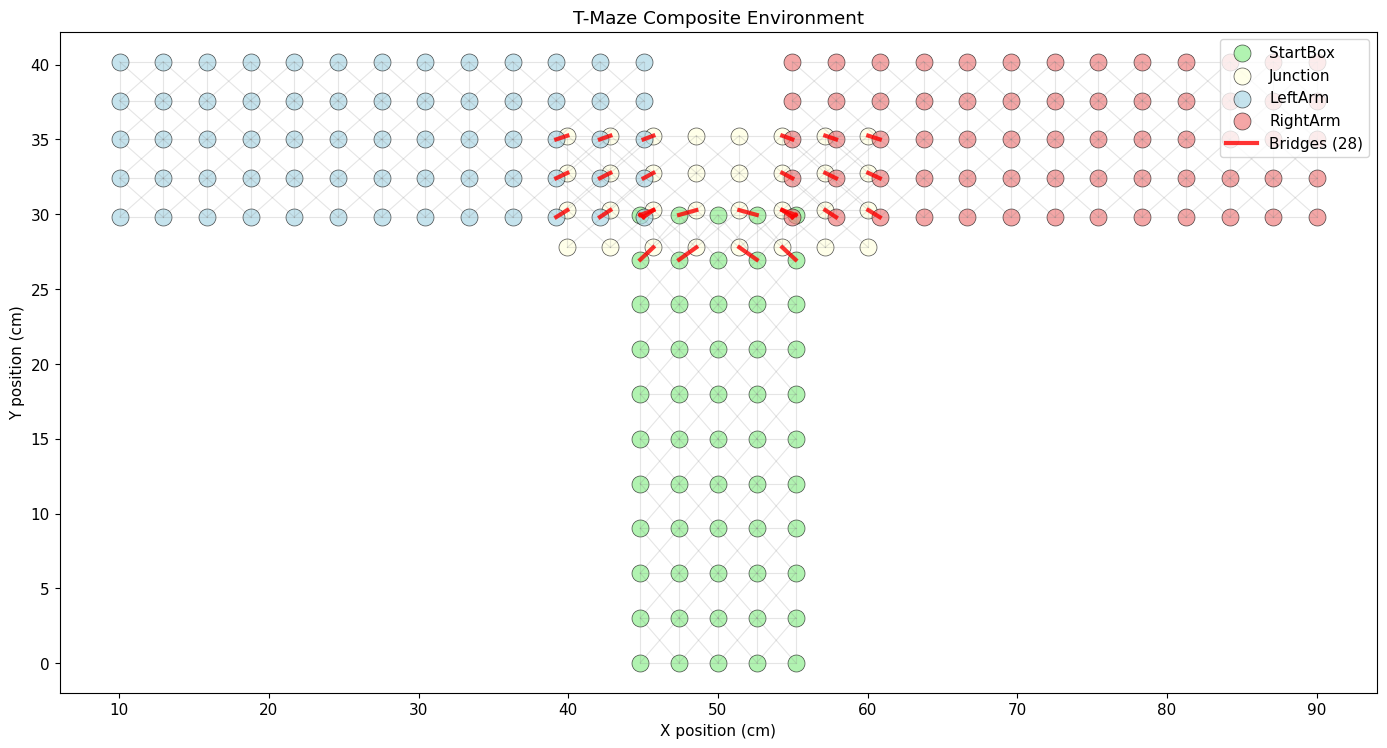

In [14]:
# Visualize the T-maze with compartment labels
fig, ax = plt.subplots(figsize=(14, 12))

# Define colors for each compartment
compartment_colors = {
    "StartBox": "lightgreen",
    "Junction": "lightyellow",
    "LeftArm": "lightblue",
    "RightArm": "lightcoral",
}

# Plot bins colored by compartment
# Construct bin_ranges from _subenvs_info
bin_ranges = {}
for info in tmaze_composite._subenvs_info:
    env_name = info["env"].name
    bin_ranges[env_name] = (info["start_idx"], info["end_idx"] + 1)

for env_name, (start_idx, end_idx) in bin_ranges.items():
    bin_centers = tmaze_composite.bin_centers[start_idx:end_idx]
    ax.scatter(
        bin_centers[:, 0],
        bin_centers[:, 1],
        c=compartment_colors[env_name],
        s=150,
        alpha=0.7,
        edgecolors="black",
        linewidth=0.5,
        label=env_name,
    )

# Convert bridge list to set of edges for fast lookup
bridge_edges_set = set()
for (i_env, i_bin), (j_env, j_bin), _ in tmaze_composite._bridge_list:
    bin1 = tmaze_composite._subenvs_info[i_env]["start_idx"] + i_bin
    bin2 = tmaze_composite._subenvs_info[j_env]["start_idx"] + j_bin
    bridge_edges_set.add((min(bin1, bin2), max(bin1, bin2)))

# Draw all edges
for edge in tmaze_composite.connectivity.edges():
    edge_key = (min(edge[0], edge[1]), max(edge[0], edge[1]))
    is_bridge = edge_key in bridge_edges_set

    pos1 = tmaze_composite.bin_centers[edge[0]]
    pos2 = tmaze_composite.bin_centers[edge[1]]

    if is_bridge:
        ax.plot(
            [pos1[0], pos2[0]],
            [pos1[1], pos2[1]],
            "r-",
            linewidth=3,
            alpha=0.8,
            zorder=10,
        )
    else:
        ax.plot(
            [pos1[0], pos2[0]], [pos1[1], pos2[1]], "gray", alpha=0.2, linewidth=0.8
        )

# Add bridge legend entry
ax.plot(
    [],
    [],
    "r-",
    linewidth=3,
    alpha=0.8,
    label=f"Bridges ({len(tmaze_composite._bridge_list)})",
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("T-Maze Composite Environment")
ax.legend(loc="upper right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### Analyzing Paths Across Compartments

One powerful feature: finding shortest paths that traverse multiple compartments.

In [15]:
# Find path from start box to left arm
point_start = np.array([50.0, 10.0])  # In start box
point_left_end = np.array([20.0, 35.0])  # In left arm

# Map to bins
bin_start = tmaze_composite.bin_at(point_start.reshape(1, -1))[0]
bin_left_end = tmaze_composite.bin_at(point_left_end.reshape(1, -1))[0]

# Find shortest path using networkx
path = nx.shortest_path(tmaze_composite.connectivity, bin_start, bin_left_end)

print("\nPath from Start Box to Left Arm:")
print(f"  Path length: {len(path)} bins")
print(
    f"  Bin sequence: {path[:10]}..." if len(path) > 10 else f"  Bin sequence: {path}"
)

# Calculate distance
path_distance = tmaze_composite.distance_between(point_start, point_left_end)
print(f"  Geodesic distance: {path_distance:.2f} cm")


Path from Start Box to Left Arm:
  Path length: 18 bins
  Bin sequence: [np.int64(25), 15, 5, 6, 7, 8, 9, 10, np.int64(147), 142]...
  Geodesic distance: 50.92 cm


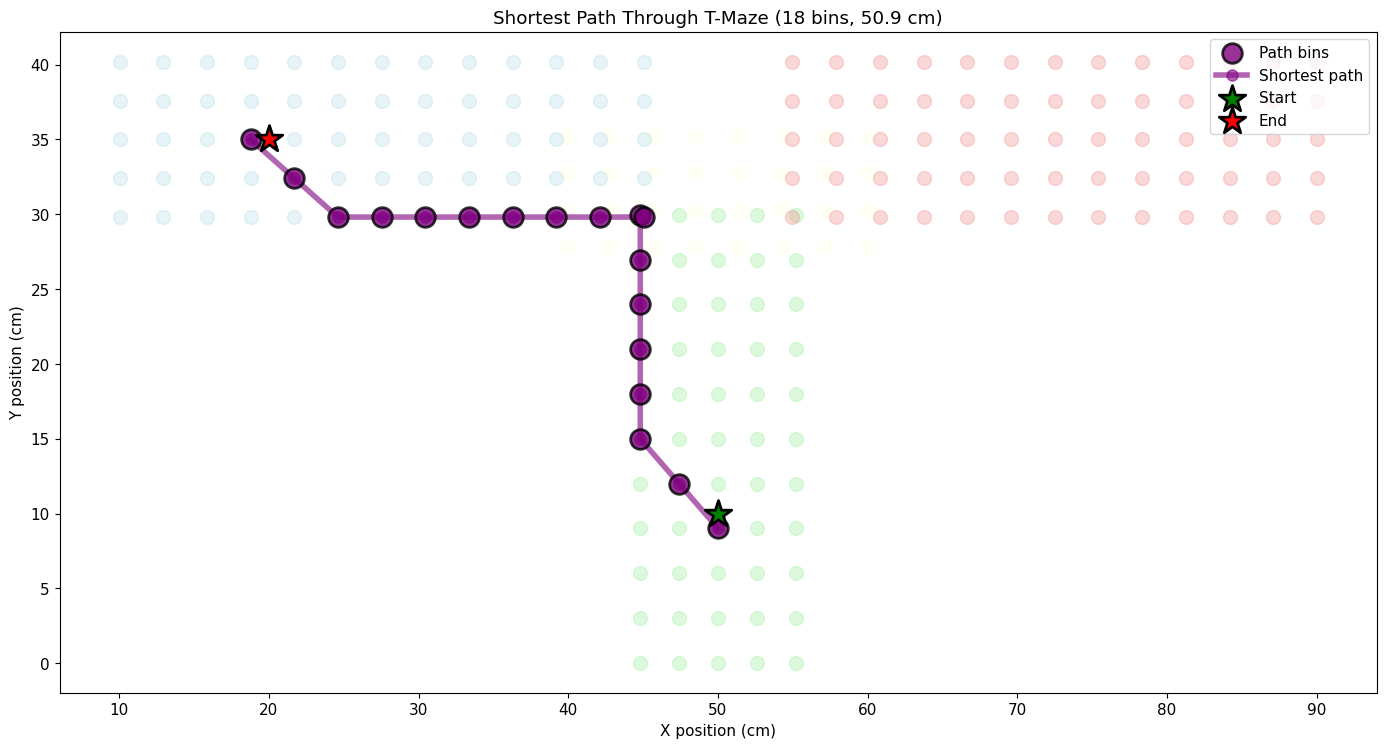

In [16]:
# Visualize the path
fig, ax = plt.subplots(figsize=(14, 12))

# Plot bins (faded)
for env_name, (start_idx, end_idx) in bin_ranges.items():
    bin_centers = tmaze_composite.bin_centers[start_idx:end_idx]
    ax.scatter(
        bin_centers[:, 0],
        bin_centers[:, 1],
        c=compartment_colors[env_name],
        s=100,
        alpha=0.3,
    )

# Highlight path bins
path_positions = tmaze_composite.bin_centers[path]
ax.scatter(
    path_positions[:, 0],
    path_positions[:, 1],
    c="purple",
    s=200,
    alpha=0.8,
    edgecolors="black",
    linewidth=2,
    label="Path bins",
    zorder=10,
)

# Draw path as line
ax.plot(
    path_positions[:, 0],
    path_positions[:, 1],
    "purple",
    linewidth=4,
    alpha=0.6,
    marker="o",
    markersize=8,
    label="Shortest path",
)

# Mark start and end
ax.scatter(
    point_start[0],
    point_start[1],
    c="green",
    s=400,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label="Start",
    zorder=15,
)
ax.scatter(
    point_left_end[0],
    point_left_end[1],
    c="red",
    s=400,
    marker="*",
    edgecolors="black",
    linewidth=2,
    label="End",
    zorder=15,
)

ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title(f"Shortest Path Through T-Maze ({len(path)} bins, {path_distance:.1f} cm)")
ax.legend(loc="upper right")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## Working with Regions in Composite Environments

You can still define and use regions within composite environments:

In [17]:
# Add regions for choice points
tmaze_composite.regions.add(
    name="LeftChoice",
    point=np.array([25.0, 35.0]),  # In left arm
)

tmaze_composite.regions.add(
    name="RightChoice",
    point=np.array([75.0, 35.0]),  # In right arm
)

tmaze_composite.regions.add(
    name="StartPoint",
    point=np.array([50.0, 10.0]),  # In start box
)

print("\nDefined Regions:")
for name in tmaze_composite.regions.list_names():
    region = tmaze_composite.regions[name]
    print(f"  {name:15s}: {region.data}")


Defined Regions:
  LeftChoice     : [25. 35.]
  RightChoice    : [75. 35.]
  StartPoint     : [50. 10.]


In [18]:
# Calculate distances between regions
start_point = tmaze_composite.regions["StartPoint"].data
left_point = tmaze_composite.regions["LeftChoice"].data
right_point = tmaze_composite.regions["RightChoice"].data

dist_start_left = tmaze_composite.distance_between(start_point, left_point)
dist_start_right = tmaze_composite.distance_between(start_point, right_point)
dist_left_right = tmaze_composite.distance_between(left_point, right_point)

print("\nInter-Region Distances:")
print(f"  Start → Left:  {dist_start_left:.2f} cm")
print(f"  Start → Right: {dist_start_right:.2f} cm")
print(f"  Left ↔ Right:  {dist_left_right:.2f} cm")


Inter-Region Distances:
  Start → Left:  45.09 cm
  Start → Right: 45.15 cm
  Left ↔ Right:  50.90 cm


## Common Pitfalls and Best Practices

### Pitfall 1: Sub-environments must have same dimensionality

In [19]:
# This would fail (mixing 2D and 1D environments)
# composite_bad = CompositeEnvironment(
#     subenvs=[env_2d, env_1d]  # Error: incompatible dimensions!
# )

print("✓ All sub-environments must have the same n_dims")
print("✓ Check env.n_dims before merging")

✓ All sub-environments must have the same n_dims
✓ Check env.n_dims before merging


### Pitfall 2: Bridge distance threshold too strict

In [20]:
# If environments are far apart, they might not connect
no_bridges_composite = CompositeEnvironment(
    subenvs=[arena_a, arena_b, arena_c],
    auto_bridge=True,
    max_mnn_distance=1.0,  # Too strict!
)

print(f"\nWith max_mnn_distance=1.0: {len(no_bridges_composite._bridge_list)} bridges")
print("⚠ Warning: Very strict threshold may result in disconnected sub-environments")
print(
    "✓ Solution: Increase threshold or use auto_bridge=True with max_mnn_distance=None"
)


With max_mnn_distance=1.0: 0 bridges
⚠ Warning: Very strict threshold may result in disconnected sub-environments
✓ Solution: Increase threshold or use auto_bridge=True with max_mnn_distance=None


### Best Practice: Check connectivity

In [21]:
# Always verify your composite is connected as expected
is_connected = nx.is_connected(tmaze_composite.connectivity)
n_components = nx.number_connected_components(tmaze_composite.connectivity)

print("\nConnectivity Check:")
print(f"  Graph connected: {is_connected}")
print(f"  Number of components: {n_components}")

if not is_connected:
    print(f"  ⚠ Warning: Graph has {n_components} disconnected components!")
    print(
        "  Consider: Increasing max_mnn_distance or checking sub-environment positions"
    )


Connectivity Check:
  Graph connected: True
  Number of components: 1


## Example 4: New CompositeEnvironment Methods (v0.1.0)

In v0.1.0, `CompositeEnvironment` gained full API parity with `Environment` class, including:
- Region queries: `bins_in_region()`, `mask_for_region()`
- Pathfinding: `shortest_path()`
- Diagnostics: `info()`
- Serialization: `save()` and `load()`

### Diagnostic Information with `.info()`

In [22]:
# Get comprehensive information about the composite environment
print("=== Composite Environment Information ===\n")
tmaze_composite.info()

# You can also get info as a string for logging
info_str = tmaze_composite.info(return_string=True)
# print(info_str)  # Uncomment to see string output

=== Composite Environment Information ===

Composite Environment Information
Number of sub-environments: 4
Total bins: 217
Dimensions: 2
Bridge edges: 28

Sub-Environment Details:
--------------------------------------------------
  [0] StartBox
      Type: RegularGrid
      Bins: 55 (composite indices: 0-54)
      Regions: 0
  [1] Junction
      Type: RegularGrid
      Bins: 32 (composite indices: 55-86)
      Regions: 0
  [2] LeftArm
      Type: RegularGrid
      Bins: 65 (composite indices: 87-151)
      Regions: 0
  [3] RightArm
      Type: RegularGrid
      Bins: 65 (composite indices: 152-216)
      Regions: 0

Bridge Statistics:
--------------------------------------------------
  Count: 28
  Min distance: 0.2646
  Max distance: 1.4276
  Mean distance: 0.8721

Composite Regions:
--------------------------------------------------
  - LeftChoice: point
  - RightChoice: point
  - StartPoint: point


### Region Queries Across Composite

Region queries work seamlessly across all sub-environments in the composite.

In [23]:
# Add regions to sub-environments - these will be accessible in composite
junction_center = env_junction.bin_centers[len(env_junction.bin_centers) // 2]
env_junction.regions.add("junction_center", point=junction_center.tolist())

left_goal = env_left.bin_centers[0]
env_left.regions.add("left_goal", point=left_goal.tolist())

# Recreate composite to include the regions
tmaze_with_regions = CompositeEnvironment(
    subenvs=[env_start, env_junction, env_left, env_right],
    auto_bridge=True,
    max_mnn_distance=6.0,
)

print("Regions available in composite:")
for region_name in tmaze_with_regions.regions:
    print(f"  - {region_name}")

# Query bins in a specific region
junction_bins = tmaze_with_regions.bins_in_region("junction_center")
print(f"\nBins in 'junction_center' region: {len(junction_bins)} bins")

# Get boolean mask for a region
junction_mask = tmaze_with_regions.mask_for_region("junction_center")
print(f"Mask shape: {junction_mask.shape}, True count: {np.sum(junction_mask)}")

Regions available in composite:
  - junction_center
  - left_goal

Bins in 'junction_center' region: 1 bins
Mask shape: (217,), True count: 1


### Pathfinding with `.shortest_path()`

Find the shortest path between any two bins in the composite, even across bridges.

In [24]:
# Import pairwise for edge iteration (more efficient than zip)
from itertools import pairwise

# Find path from start to right arm (crosses bridges through junction)
source_bin = 0  # First bin in start box
target_bin = tmaze_with_regions.n_bins - 5  # Bin in right arm

path = tmaze_with_regions.shortest_path(source_bin, target_bin)

if path:
    print(f"\nShortest path from bin {source_bin} to bin {target_bin}:")
    print(f"  Path length: {len(path)} bins")
    print("  Path traverses: ", end="")

    # Identify which sub-environments the path crosses
    start_n_bins = env_start.n_bins
    junction_n_bins = env_junction.n_bins
    left_n_bins = env_left.n_bins

    in_start = any(b < start_n_bins for b in path)
    in_junction = any(start_n_bins <= b < start_n_bins + junction_n_bins for b in path)
    in_left = any(
        start_n_bins + junction_n_bins
        <= b
        < start_n_bins + junction_n_bins + left_n_bins
        for b in path
    )
    in_right = any(b >= start_n_bins + junction_n_bins + left_n_bins for b in path)

    compartments = []
    if in_start:
        compartments.append("Start")
    if in_junction:
        compartments.append("Junction")
    if in_left:
        compartments.append("Left")
    if in_right:
        compartments.append("Right")

    print(" → ".join(compartments))

    # Calculate total path distance using pairwise iteration
    total_distance = sum(
        tmaze_with_regions.connectivity[u][v]["distance"] for u, v in pairwise(path)
    )
    print(f"  Total distance: {total_distance:.2f} units")


Shortest path from bin 0 to bin 212:
  Path length: 24 bins
  Path traverses: Start → Junction → Right
  Total distance: 68.80 units


### Pathfinding Example: No Path Between Disconnected Components

In [25]:
import warnings

# Create a composite without bridges to demonstrate warning
disconnected_composite = CompositeEnvironment(
    subenvs=[arena_a, arena_b], auto_bridge=False
)

# Try to find path between disconnected sub-environments
source = 0  # In arena_a
target = arena_a.n_bins + 5  # In arena_b

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    path = disconnected_composite.shortest_path(source, target)
    if len(w) > 0:
        print(f"⚠ Warning captured: {w[0].message}")

print(f"Path result: {path} (empty list indicates no path exists)")

⚠ Warning captured: No path found between bin 0 and bin 85. The bins may be in disconnected components. Returning empty path.
Path result: [] (empty list indicates no path exists)


### Saving and Loading Composite Environments

In [26]:
import tempfile
from pathlib import Path

# Save composite environment to file
with tempfile.TemporaryDirectory() as tmpdir:
    filepath = Path(tmpdir) / "my_composite_env.pkl"

    # Save
    tmaze_with_regions.save(str(filepath))
    print(f"Saved composite to: {filepath}")
    print(f"File size: {filepath.stat().st_size / 1024:.2f} KB")

    # Load
    loaded_composite = CompositeEnvironment.load(str(filepath))

    # Verify loaded composite matches original
    print("\nVerifying loaded composite:")
    print(
        f"  n_bins: {loaded_composite.n_bins} (original: {tmaze_with_regions.n_bins})"
    )
    print(
        f"  n_dims: {loaded_composite.n_dims} (original: {tmaze_with_regions.n_dims})"
    )
    print(
        f"  n_sub_envs: {len(loaded_composite._subenvs_info)} (original: {len(tmaze_with_regions._subenvs_info)})"
    )
    print(
        f"  n_bridges: {len(loaded_composite._bridge_list)} (original: {len(tmaze_with_regions._bridge_list)})"
    )
    print(f"  Regions preserved: {list(loaded_composite.regions.keys())}")

    # Test that loaded composite works
    test_points = np.array([[5.0, 5.0]])
    bins_loaded = loaded_composite.bin_at(test_points)
    bins_original = tmaze_with_regions.bin_at(test_points)
    print(f"  bin_at() test: loaded={bins_loaded[0]}, original={bins_original[0]}")

    print("\n✓ Save/load preserves all composite structure and functionality")

Saved composite to: /var/folders/86/m147b4k17lddvs_xsw0mj2zw0000gn/T/tmpubfcaj61/my_composite_env.pkl
File size: 110.04 KB

Verifying loaded composite:
  n_bins: 217 (original: 217)
  n_dims: 2 (original: 2)
  n_sub_envs: 4 (original: 4)
  n_bridges: 28 (original: 28)
  Regions preserved: ['junction_center', 'left_goal']
  bin_at() test: loaded=-1, original=-1

✓ Save/load preserves all composite structure and functionality


## Key Takeaways

Congratulations! You now understand composite environments in neurospatial:

1. **`CompositeEnvironment`** merges multiple `Environment` instances into one unified space

2. **Automatic bridge inference** uses mutual nearest neighbors (MNN) to connect sub-environments

3. **`max_mnn_distance` parameter** controls which environments connect (None = no limit)

4. **Full API parity with Environment** (v0.1.0):
   - Spatial queries: `bin_at()`, `distance_between()`, `contains()`
   - Region queries: `bins_in_region()`, `mask_for_region()`
   - Pathfinding: `shortest_path()` (works across bridges!)
   - Diagnostics: `info()` (shows composite structure and bridge stats)
   - Serialization: `save()` and `load()` (persist composite environments)

5. **Use cases**:
   - Multi-room experiments
   - Complex mazes with compartments
   - Context switching paradigms
   - Multi-scale analysis

6. **Best practices**:
   - Verify all sub-environments have same `n_dims`
   - Check connectivity after creation (`nx.is_connected()`)
   - Tune `max_mnn_distance` based on your spatial scale
   - Visualize bridges to verify expected connections
   - Use `info()` to inspect composite structure
   - Save composites to avoid re-computing bridges

## Next Steps

In the next notebook (**07_advanced_operations.ipynb**), you'll learn:
- Advanced path finding and geodesic distances
- Alignment and coordinate transformations
- Mapping probability distributions between environments
- Graph analysis and connectivity metrics

## Exercises (Optional)

1. Create a plus-maze with 4 arms and analyze paths between opposite arms
2. Build a composite with 5 circular arenas and find optimal `max_mnn_distance`
3. Calculate average bridge length for different environment configurations
4. Create a composite T-maze and compute occupancy separately for each compartment